In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import math

import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}

path = "../data/"

train_df = pd.read_csv(path + "train_data.csv", dtype=dtype, parse_dates=["Timestamp"])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

test_df = pd.read_csv(path+"test_data.csv", dtype=dtype, parse_dates=["Timestamp"])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

display(train_df.head(2))
display(test_df.head(2))
display(train_df.info())
display(test_df.info())

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int16         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int8          
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int16         
dtypes: datetime64[ns](1), int16(2), int8(1), object(2)
memory usage: 62.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260114 entries, 0 to 260113
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   userID            260114 non-null  int16         
 1   assessmentItemID  260114 non-null  object        
 2   testId            260114 non-null  object        
 3   answerCode        260114 non-null  int8          
 4   Timestamp         260114 non-null  datetime64[ns]
 5   KnowledgeTag      260114 non-null  int16         
dtypes: datetime64[ns](1), int16(2), int8(1), object(2)
memory usage: 7.2+ MB


None

In [3]:
print(train_df['userID'].nunique())
print(len(set(train_df['userID']) - set(test_df['userID'])))

print(train_df['testId'].nunique())
print(len(set(train_df['testId']) - set(test_df['testId'])))
print(len(set(test_df['testId']) - set(train_df['testId'])))

6698
6698
1537
0
0


겹치는 유저x / test는 모두 동일하게 겹침

유저의 정보보다는 test와 관련된 정보에 더 치중하는게 맞을 듯 해보임..

문제 경과 시간 (elapsedTime)

In [4]:
train_df['elapsedTime'] = train_df['Timestamp'].diff(periods=1).astype('timedelta64[s]')
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsedTime
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,6632178.0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0


In [5]:
train_df['Timestamp'].dt.year.unique()

array([2020, 2019])

In [6]:
print(len(train_df[train_df['Timestamp'].dt.year == 2019]))
print(len(train_df[train_df['Timestamp'].dt.year == 2020]))
print('---'*30)
print(len(test_df[test_df['Timestamp'].dt.year == 2019]))
print(len(test_df[test_df['Timestamp'].dt.year == 2020]))

19
2266567
------------------------------------------------------------------------------------------
5
260109


train에서 19년 문제가 19개 섞여있음
test에서 5개 섞여있음

모든 문제는 1번은 모두 동일하게 풀었나?

In [7]:
print("문제 1번 개수 : ",train_df[train_df['assessmentItemID'].str[-3:] == '001']['assessmentItemID'].nunique())
print("문제 총 개수 : ",train_df['testId'].nunique())

문제 1번 개수 :  1531
문제 총 개수 :  1537


1번을 안풀고 진행하는 경우도 있는 것 같음 (모두 순서대로 풀었다느 소리는 아닌 듯)

### elapsedTime 처리하기

1. testID가 위아래 행이 다를 경우 다른 시험문제이므로 아래 행을 0으로 처리
2. testID가 위아래가 같은데 유저가 다른 경우가 있음 -> 동시에 비교해서 0으로 처리

In [8]:
t = train_df.loc[:, ['userID','assessmentItemID','testId']]
t['testId2'] = t['testId'].shift()
t['userID2'] = t['userID'].shift()
# testId2는 같은데 userID가 다른 경우가 있음
t_idx = t[(t['testId2'] != t['testId']) | ((t['testId2'] == t['testId']) & (t['userID2'] != t['userID']))].index

In [9]:
t_idx

Int64Index([      0,       6,      13,      20,      27,      33,      40,
                 47,      55,      63,
            ...
            2266536, 2266539, 2266546, 2266552, 2266557, 2266562, 2266567,
            2266572, 2266577, 2266582],
           dtype='int64', length=374597)

In [10]:
train_df.loc[t_idx, 'elapsedTime'] = 0.0

In [11]:
train_df.iloc[[27856,27857,27858,27859,27860]]
# 2번을 먼저 풀고 1번을 푸는 경우도 있음

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsedTime
27856,37,A040110005,A040000110,1,2020-10-23 08:10:04,8238,197.0
27857,38,A030014002,A030000014,0,2020-04-07 05:28:41,7310,0.0
27858,38,A030014001,A030000014,1,2020-04-07 06:01:25,7309,1964.0
27859,38,A030014003,A030000014,1,2020-04-07 06:06:25,7309,300.0
27860,38,A030014004,A030000014,0,2020-04-07 06:09:12,7310,167.0


In [12]:
train_df[train_df['elapsedTime'] < 0]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsedTime


유저의 평균 정답률 -> 생각해보니 필요한가 싶음... -> test에는 같은 user가 없어서 오히려 정답률을 낮출 가능성도 있어보임..

In [13]:
def percentile(s):
    return np.sum(s) / len(s)

In [14]:
stu_groupby = train_df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.head(3)

,assessmentItemID,answerCode
userID,,
0,745,0.630872
1,933,0.853162
2,276,0.612319


In [15]:
stu_groupby = stu_groupby.rename(columns={"answerCode":"userAnswerRate"})
stu_groupby = stu_groupby.reset_index()
stu_groupby

,userID,assessmentItemID,userAnswerRate
0,0,745,0.630872
1,1,933,0.853162
2,2,276,0.612319
3,5,833,0.795918
4,6,921,0.442997
...,...,...,...
6693,7436,15,0.466667
6694,7437,16,0.375000
6695,7438,16,0.750000
6696,7440,15,0.400000


In [16]:
train_df = train_df.merge(stu_groupby[['userID','userAnswerRate']], on='userID', how='left')
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsedTime,userAnswerRate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,0.630872
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0,0.630872
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0,0.630872
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,0.630872
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0,0.630872
...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0,0.555556
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.0,0.555556
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0,0.555556
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0,0.555556


문항별 평균 정답률

In [17]:
itemID_groupby = train_df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
itemID_groupby = itemID_groupby.rename(columns={"answerCode":"itemIDAnswerRate"})
itemID_groupby = itemID_groupby.reset_index()
itemID_groupby

,assessmentItemID,userID,itemIDAnswerRate
0,A010001001,317,0.930599
1,A010001002,317,0.958991
2,A010001003,317,0.905363
3,A010001004,317,0.949527
4,A010001005,317,0.886435
...,...,...,...
9449,A090074002,45,0.444444
9450,A090074003,45,0.577778
9451,A090074004,45,0.333333
9452,A090074005,45,0.400000


In [18]:
train_df = train_df.merge(itemID_groupby[['assessmentItemID','itemIDAnswerRate']], on='assessmentItemID', how='left')
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsedTime,userAnswerRate,itemIDAnswerRate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,0.630872,0.982063
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0,0.630872,0.964126
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0,0.630872,0.910314
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,0.630872,0.968610
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0,0.630872,0.941704
...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0,0.555556,0.435252
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.0,0.555556,0.649635
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0,0.555556,0.635036
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0,0.555556,0.791971


### 한 시험지를 푸는데 걸린 시간

In [19]:
user_solve_test_time = train_df.groupby(['userID', 'testId'])['elapsedTime'].sum()\
                                             .groupby(level=0).cumsum().reset_index()

In [20]:
user_solve_test_time.rename(columns={"elapsedTime":"testSolveTime"}, inplace=True)
user_solve_test_time.sort_values('testSolveTime')

,userID,testId,testSolveTime
364129,7118,A020000100,5.0
357957,6168,A020000075,6.0
136622,1264,A030000002,7.0
347779,5324,A030000080,7.0
82763,740,A070000002,7.0
...,...,...,...
333507,4631,A040000168,4836332.0
333508,4631,A040000170,4836696.0
333509,4631,A040000172,4837041.0
333510,4631,A040000174,4837232.0


In [21]:
train_df = train_df.merge(user_solve_test_time, on=['userID','testId'], how='left')
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsedTime,userAnswerRate,itemIDAnswerRate,testSolveTime
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,0.630872,0.982063,2231.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0,0.630872,0.964126,2231.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0,0.630872,0.910314,2231.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,0.630872,0.968610,2231.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0,0.630872,0.941704,2231.0
...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0,0.555556,0.435252,220.0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.0,0.555556,0.649635,350.0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0,0.555556,0.635036,350.0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0,0.555556,0.791971,350.0


### testId를 통한 카테고리 분류 (의미가 있다면 catboost를 사용할 수 있을 것 같음)

In [22]:
train_df['Category'] = train_df['testId'].apply(lambda x : x[:4])
train_df['subCategory'] = train_df['testId'].apply(lambda x : x[-3:])

In [23]:
df = train_df.copy(deep=True)
df['Category'] = df['testId'].apply(lambda x : x[:4])
df['subCategory'] = df['testId'].apply(lambda x : x[-3:])
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsedTime,userAnswerRate,itemIDAnswerRate,testSolveTime,Category,subCategory
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,0.630872,0.982063,2231.0,A060,001
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0,0.630872,0.964126,2231.0,A060,001
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0,0.630872,0.910314,2231.0,A060,001
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,0.630872,0.968610,2231.0,A060,001
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0,0.630872,0.941704,2231.0,A060,001
...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0,0.555556,0.435252,220.0,A030,071
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.0,0.555556,0.649635,350.0,A040,165
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0,0.555556,0.635036,350.0,A040,165
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0,0.555556,0.791971,350.0,A040,165


In [24]:
print(df['subCategory'].nunique())
print(max(df['subCategory'].unique()))

198
198


In [25]:
display(df.groupby(['Category'])['subCategory'].count())
df.groupby(['Category'])['subCategory'].value_counts()

Category
A010    272082
A020    268327
A030    273762
A040    267323
A050    275773
A060    264434
A070    279164
A080    246336
A090    119385
Name: subCategory, dtype: int64

Category  subCategory
A010      018            2536
          017            2480
          060            2191
          137            2163
          021            1908
                         ... 
A090      006             288
          008             288
          072             270
          073             270
          074             270
Name: subCategory, Length: 1537, dtype: int64

In [26]:
tdf = df.groupby(['userID', 'Category'])['subCategory'].count().reset_index()
tdf

,userID,Category,subCategory
0,0,A020,36
1,0,A060,346
2,0,A080,363
3,1,A040,581
4,1,A090,352
...,...,...,...
17747,7438,A080,6
17748,7440,A030,10
17749,7440,A050,5
17750,7441,A030,5


<AxesSubplot: xlabel='subCategory', ylabel='count'>

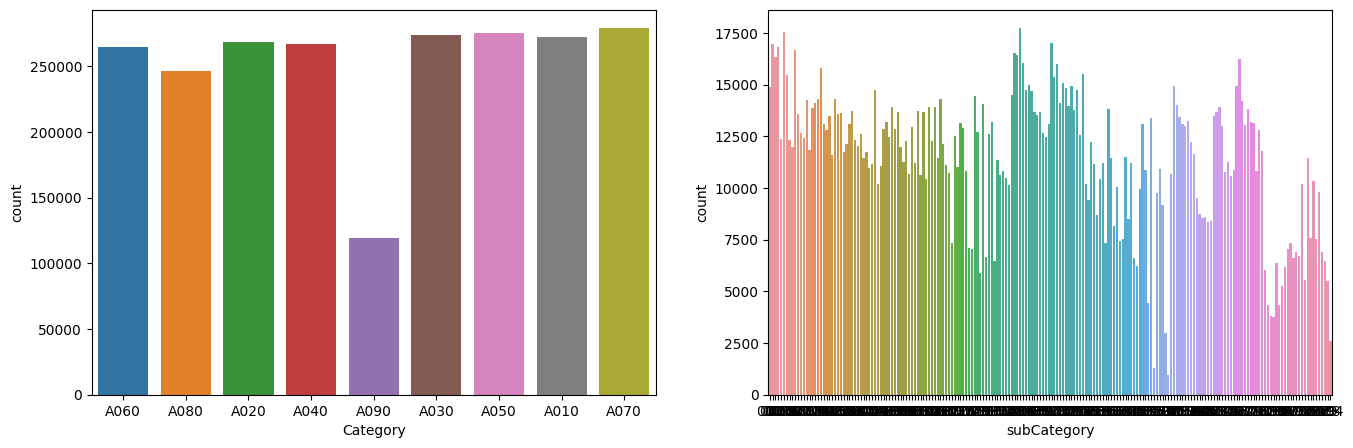

In [27]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
sns.countplot(data=df, x='Category', ax=ax[0])
sns.countplot(data=df, x='subCategory', ax=ax[1])

--> category와 subcategory를 categorical 변수로 주고 후에 timestamp를 제거한 catboost를 ensemble할 수 있어보임

In [28]:
from sklearn.preprocessing import LabelEncoder
import time
from datetime import datetime

cate_cols = ["assessmentItemID", "testId", "KnowledgeTag", 'Category', 'subCategory']
is_train=True

for col in cate_cols:
    le = LabelEncoder()
    if is_train:
        # For UNKNOWN class
        a = train_df[col].unique().tolist() + ["unknown"]
        le.fit(a)

    # 모든 컬럼이 범주형이라고 가정
    train_df[col] = train_df[col].astype(str)
    test = le.transform(train_df[col])
    train_df[col] = test

def convert_time(s):
    timestamp = time.mktime(
        datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()
    )
    return int(timestamp)

train_df["Timestamp"] = train_df["Timestamp"].astype(str)
train_df["Timestamp"] = train_df["Timestamp"].apply(convert_time)
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsedTime,userAnswerRate,itemIDAnswerRate,testSolveTime,Category,subCategory
0,0,5354,975,1,1585009031,618,0.0,0.630872,0.982063,2231.0,5,0
1,0,5355,975,1,1585009034,619,3.0,0.630872,0.964126,2231.0,5,0
2,0,5356,975,1,1585009042,619,8.0,0.630872,0.910314,2231.0,5,0
3,0,5357,975,1,1585009049,619,7.0,0.630872,0.968610,2231.0,5,0
4,0,5358,975,1,1585009056,619,7.0,0.630872,0.941704,2231.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,2373,456,0,1591339821,375,24.0,0.555556,0.435252,220.0,2,70
2266582,7441,3909,748,1,1597971999,784,0.0,0.555556,0.649635,350.0,3,164
2266583,7441,3910,748,1,1597972010,784,11.0,0.555556,0.635036,350.0,3,164
2266584,7441,3911,748,1,1597972056,784,46.0,0.555556,0.791971,350.0,3,164


In [29]:
from sklearn.preprocessing import MinMaxScaler
scaling_columns = ["elapsedTime", "userAnswerRate", "itemIDAnswerRate", "testSolveTime"]
sc = MinMaxScaler()
for col in scaling_columns:
    train_df[col] = sc.fit_transform(train_df[[col]])
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsedTime,userAnswerRate,itemIDAnswerRate,testSolveTime,Category,subCategory
0,0,5354,975,1,1585009031,618,0.000000e+00,0.630872,0.984954,0.000460,5,0
1,0,5355,975,1,1585009034,619,6.233778e-07,0.630872,0.966010,0.000460,5,0
2,0,5356,975,1,1585009042,619,1.662341e-06,0.630872,0.909180,0.000460,5,0
3,0,5357,975,1,1585009049,619,1.454548e-06,0.630872,0.970746,0.000460,5,0
4,0,5358,975,1,1585009056,619,1.454548e-06,0.630872,0.942331,0.000460,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,2373,456,0,1591339821,375,4.987022e-06,0.555556,0.407467,0.000044,2,70
2266582,7441,3909,748,1,1597971999,784,0.000000e+00,0.555556,0.633877,0.000071,3,164
2266583,7441,3910,748,1,1597972010,784,2.285719e-06,0.555556,0.618459,0.000071,3,164
2266584,7441,3911,748,1,1597972056,784,9.558459e-06,0.555556,0.784197,0.000071,3,164


<AxesSubplot: title={'center': 'Person Correlation of Features'}>

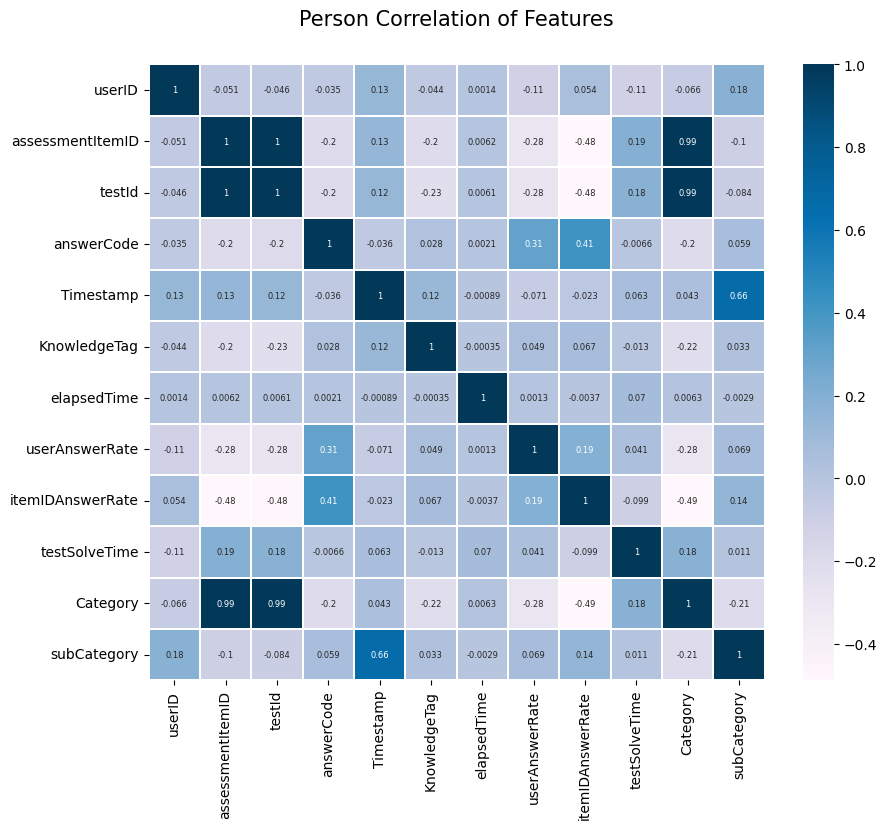

In [30]:
colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(train_df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 6})

In [31]:
train_df.drop(columns=['testId','Category'])
train_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'elapsedTime', 'userAnswerRate', 'itemIDAnswerRate',
       'testSolveTime', 'Category', 'subCategory'],
      dtype='object')

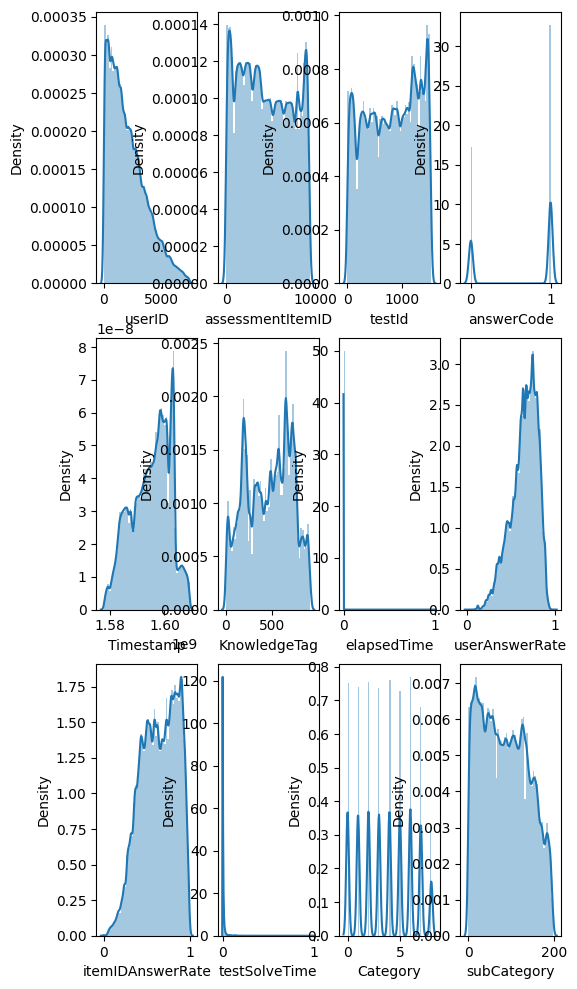

In [34]:
fig, axes = plt.subplots(3,4, figsize=(6,12))

for idx, col in enumerate(train_df.columns):
    sns.distplot(train_df[col], ax= axes[idx//4,idx%4])

In [37]:
import os
# os.mkdir()

True

In [45]:
import pandas as pd

train_df = pd.read_csv('../data/train_data.csv')
test_df = pd.read_csv('../data/test_data.csv')

In [46]:
len(train_df)

2266586

In [48]:
test_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag'],
      dtype='object')

In [56]:
idx = test_df[test_df['answerCode'] == -1].index
pred_df = test_df.iloc[idx]
concat_df = test_df.iloc[~idx]

train_df = train_df.append(concat_df)

In [57]:
# train_df.to_csv("./train_data2.csv", index=False)
# pred_df.to_csv("./test_data2.csv", index=False)

In [61]:
train_df = train_df.sort_values(["userID", 'Timestamp']).reset_index(drop=True)

In [62]:
train_df.to_csv("./train_data2.csv", index=False)